In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import zipfile as zip
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATE_COLUMN_NAME="Date"
VALUE_COLUMN_NAME="Sunspot Number"
BATCH_SIZE = 256
BUFFER_SIZE = 10000
STEPS=12

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mikitadubovik","key":"4bb7f20667c695e50f46ad3ee57de20d"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d robervalt/sunspots

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 44.2MB/s]


In [0]:
with zip.ZipFile("/content/sunspots.zip") as zip_file:
    zip_file.extractall("/content/")

In [0]:
dataset=pd.read_csv("/content/Sunspots.csv")

In [8]:
dataset.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [0]:
del dataset['Unnamed: 0']

In [0]:
dataset.columns=[DATE_COLUMN_NAME,VALUE_COLUMN_NAME]
dataset[DATE_COLUMN_NAME]=pd.to_datetime(dataset[DATE_COLUMN_NAME])

In [11]:
dataset.head()

,Date,Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


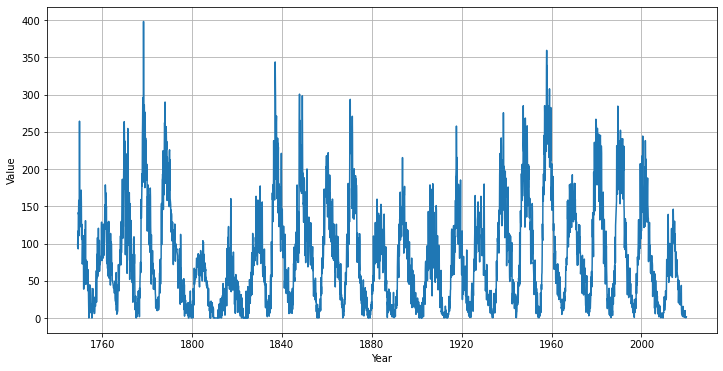

In [12]:
plt.figure(figsize=(12,6))
plt.plot(dataset[DATE_COLUMN_NAME], dataset[VALUE_COLUMN_NAME], "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

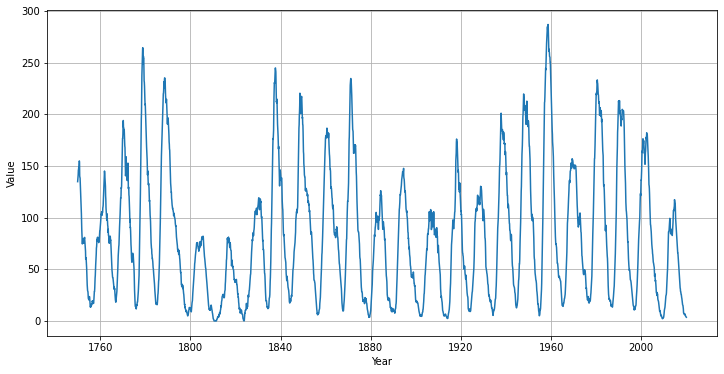

In [13]:
sunspot_number=dataset[VALUE_COLUMN_NAME]
trend=sunspot_number.rolling(12).mean()
plt.figure(figsize=(12,6))
plt.plot(dataset[DATE_COLUMN_NAME], trend, "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

Text(0.5, 0, 'Year')

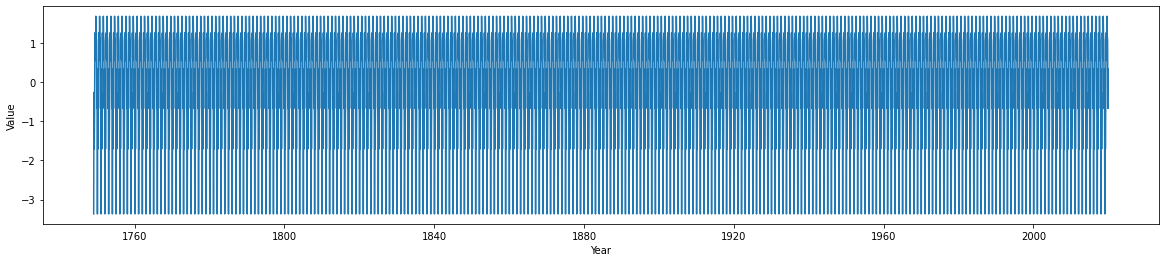

In [208]:
import statsmodels.tsa.seasonal as seasonal
dataset.index = dataset[DATE_COLUMN_NAME]
decomposition = seasonal.seasonal_decompose(dataset[VALUE_COLUMN_NAME], model='additive')

plt.figure(figsize=(20,4))
plt.plot(decomposition.seasonal)
plt.ylabel("Value")
plt.xlabel("Year")

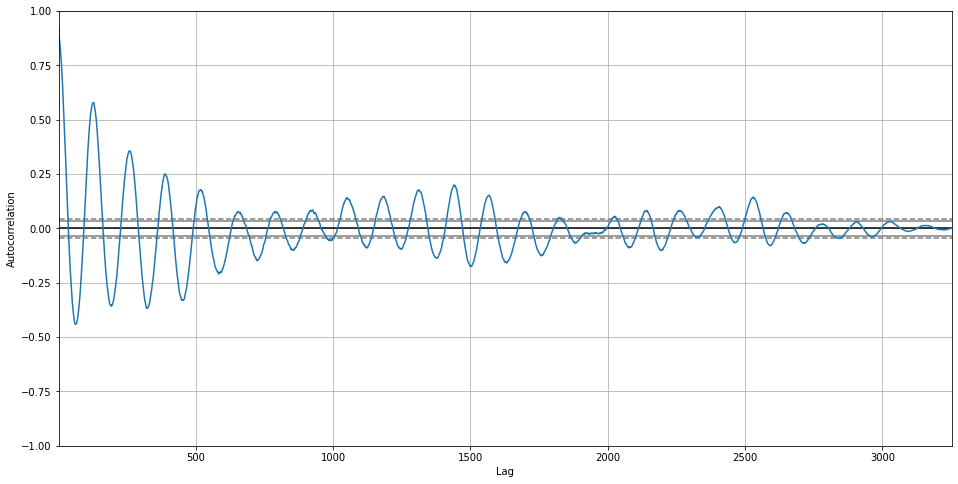

In [14]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(dataset[VALUE_COLUMN_NAME])

In [0]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=False)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_dataset, validate_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42, shuffle=False)
train_dataset = train_dataset.reset_index(drop=True)
validate_dataset = validate_dataset.reset_index(drop=True)

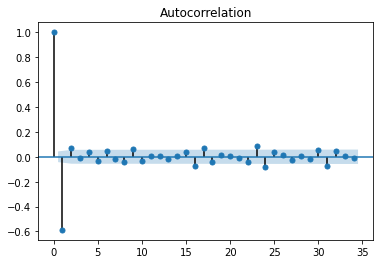

In [164]:
train_dataset_diff1=train_dataset[VALUE_COLUMN_NAME].diff().fillna(train_dataset[VALUE_COLUMN_NAME])
train_dataset_diff2=train_dataset_diff1.diff().fillna(train_dataset_diff1)
plot_acf(train_dataset_diff2)
plt.show()

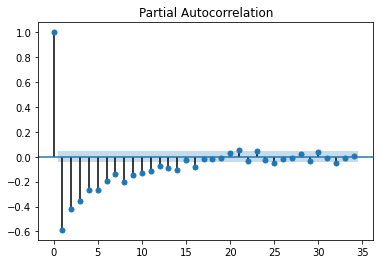

In [165]:
plot_pacf(train_dataset_diff2)
plt.show()

In [166]:
X = dataset[VALUE_COLUMN_NAME].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train_dataset[VALUE_COLUMN_NAME].values]
predictions = list()
for t in range(len(test_dataset[VALUE_COLUMN_NAME])):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_dataset[VALUE_COLUMN_NAME].values[t]
	history.append(obs)
error = mean_squared_error(test_dataset[VALUE_COLUMN_NAME].values, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 538.977


Text(0, 0.5, 'Value')

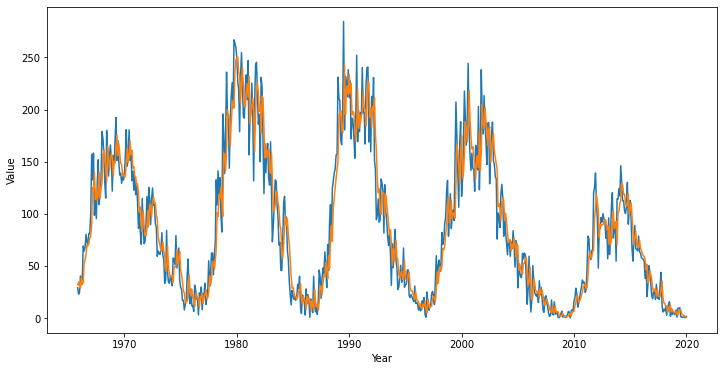

In [169]:
plt.figure(figsize=(12,6))
plt.plot(test_dataset[DATE_COLUMN_NAME], test_dataset[VALUE_COLUMN_NAME])
plt.plot(test_dataset[DATE_COLUMN_NAME], predictions)
plt.xlabel("Year")
plt.ylabel("Value")

In [0]:
train_sunspot_number=train_dataset[VALUE_COLUMN_NAME]
validate_sunspot_number=validate_dataset[VALUE_COLUMN_NAME]

In [0]:
train_sunspot_number_mean=train_sunspot_number.mean()
train_sunspot_number_std=train_sunspot_number.std()
train_sunspot_number=(train_sunspot_number-train_sunspot_number_mean)/train_sunspot_number_std

validate_sunspot_number=(validate_sunspot_number-train_sunspot_number_mean)/train_sunspot_number_std

In [0]:
def univariate_data(dataset, history_size):
  data = []
  labels = []

  start_index = history_size
  end_index = len(dataset)

  for i in range(start_index, end_index):
    data.append(dataset[i-history_size:i])
    labels.append(dataset[i])

  x=np.array(data)
  y=np.array(labels)

  return x.reshape((x.shape[0],history_size,1)), y

In [0]:
x_train, y_train = univariate_data(train_sunspot_number, STEPS)
x_validate, y_validate = univariate_data(train_sunspot_number, STEPS)

In [0]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(optimizer='adam', loss='mae')

In [178]:
model.fit(train_data,epochs=10,validation_data=val_data, steps_per_epoch=100, validation_steps=30)

Epoch 1/10
100/100 [==============================] - 2s 17ms/step - loss: 0.4291 - val_loss: 0.3600
Epoch 2/10
100/100 [==============================] - 1s 11ms/step - loss: 0.3425 - val_loss: 0.3284
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.3192 - val_loss: 0.3089
Epoch 4/10
100/100 [==============================] - 1s 11ms/step - loss: 0.3035 - val_loss: 0.2970
Epoch 5/10
100/100 [==============================] - 1s 11ms/step - loss: 0.2970 - val_loss: 0.2914
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 0.2922 - val_loss: 0.2882
Epoch 7/10
100/100 [==============================] - 1s 11ms/step - loss: 0.2903 - val_loss: 0.2864
Epoch 8/10
100/100 [==============================] - 1s 11ms/step - loss: 0.2875 - val_loss: 0.2838
Epoch 9/10
100/100 [==============================] - 1s 11ms/step - loss: 0.2857 - val_loss: 0.2818
Epoch 10/10
100/100 [==============================] - 1s 11ms/step - loss: 0.2837 - val_lo

In [0]:
predictions=model.predict(x_validate)

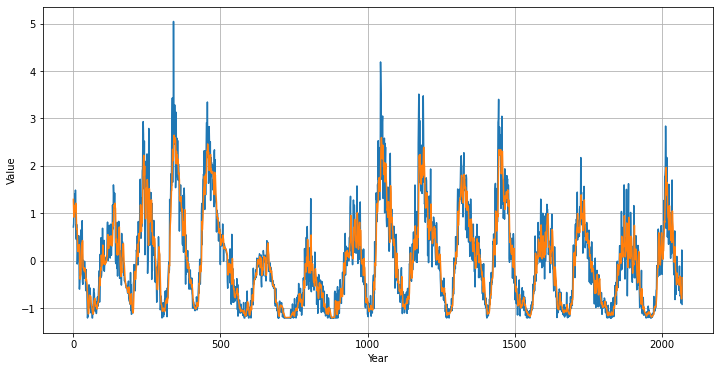

In [180]:
times=list(range(1,len(y_validate)+1))
plt.figure(figsize=(12,6))
plt.plot(times, y_validate, "-",)
plt.plot(times, predictions, "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

In [181]:
model.evaluate(val_data,steps=STEPS)

12/12 [==============================] - 0s 4ms/step - loss: 0.2768


0.27675244212150574

In [0]:
test_sunspot_number=test_dataset[VALUE_COLUMN_NAME]
test_sunspot_number=(test_sunspot_number-train_sunspot_number_mean)/train_sunspot_number_std
x_test, y_test = univariate_data(test_sunspot_number, STEPS)

In [0]:
predictions=model.predict(x_test)

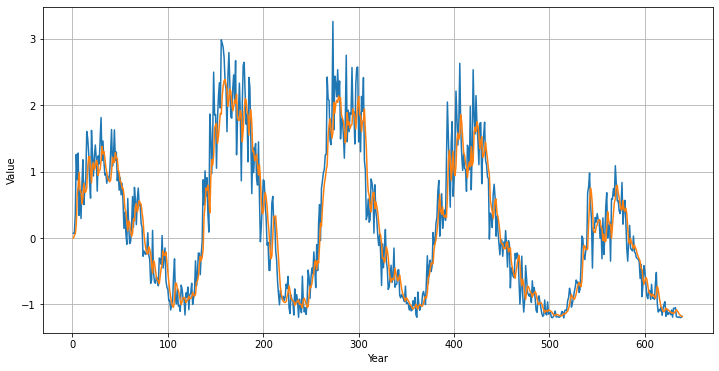

In [184]:
times=list(range(1,len(y_test)+1))
plt.figure(figsize=(12,6))
plt.plot(times, y_test, "-",)
plt.plot(times, predictions, "-",)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

In [0]:
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

In [187]:
model.evaluate(test_data,steps=STEPS)

12/12 [==============================] - 0s 4ms/step - loss: 0.2692


0.2691899240016937